# How has the pandemic affected bike usage?

Let's start by looking at historical trends on bike counts - starting with 2019. I downloaded the data from https://donnees.montreal.ca/ville-de-montreal/velos-comptage. Although the data we use is sampled at 15' intervals, I resampled at a daily cadence for this analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Text(0.5, 1.0, '2019 counter data')

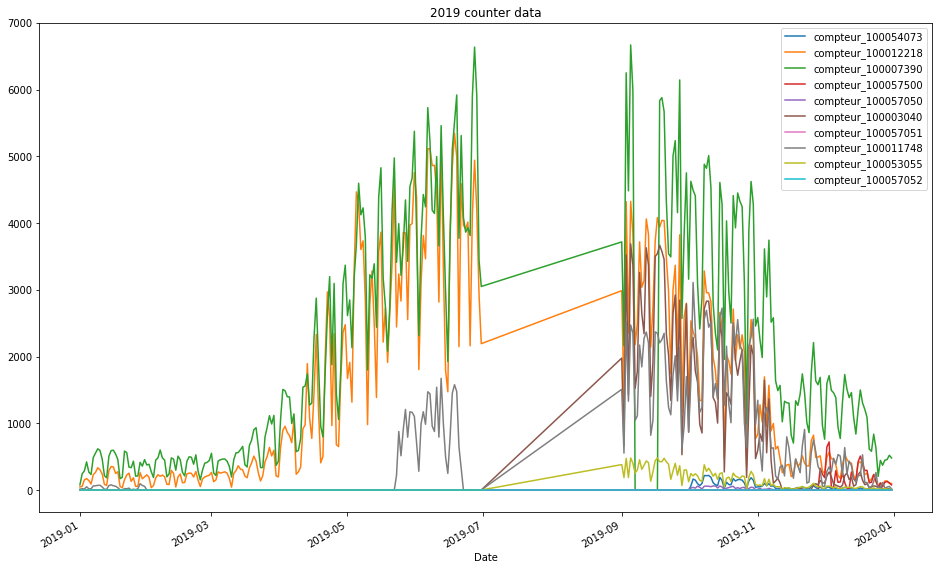

In [2]:
plt.figure(figsize=(16, 10))
df = pd.read_csv('comptage_velo_2019.csv')

df = df.set_index(pd.DatetimeIndex(pd.to_datetime(df.Date, format="%d/%m/%Y %H:%M")))
df = df.resample('1D').sum()

# There was a clerical error in the construction of the 2019 dataset. 
# July is present twice while August is not there at all. Furthermore, there's a 31st of July 
# in the dataset, so it's not clear if the July data is actually August. Drop the data
df = df[(df.index < '2019-07-01') | (df.index >= '2019-09-01')]
df2019 = df
df.iloc[:, ::5].plot(ax=plt.gca())
plt.title('2019 counter data')

Text(0.5, 1.0, '2020 counter data')

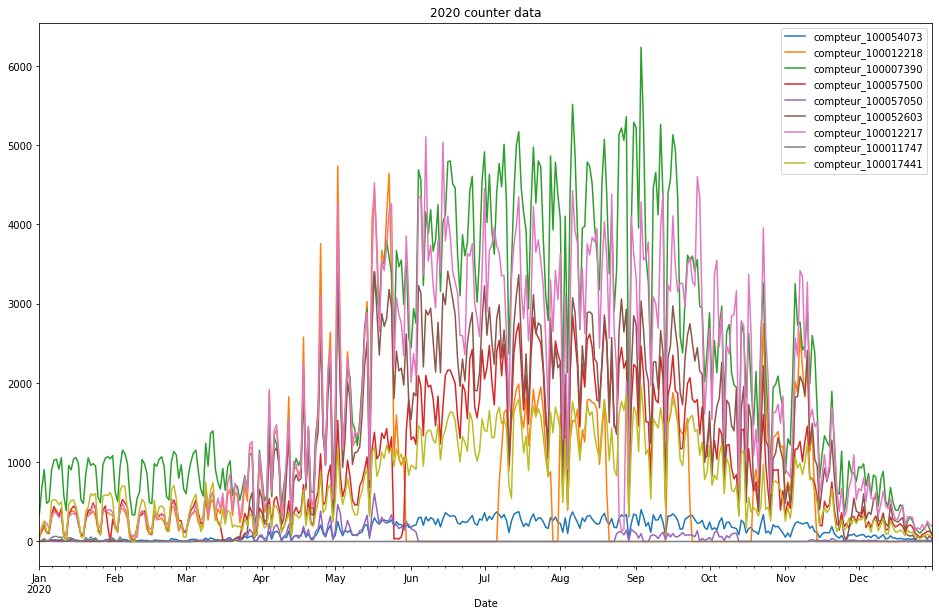

In [3]:
plt.figure(figsize=(16, 10))
df = pd.read_csv('comptage_velo_2020.csv')

df = df.set_index(pd.DatetimeIndex(pd.to_datetime(df.Date, format="%Y-%m-%d %H:%M")))
df = df.resample('1D').sum()
df2020 = df
df.iloc[:, ::5].plot(ax=plt.gca())
plt.title('2020 counter data')

It's messy, but it looks promising. Let's look at counters in both years to see if they're comparable through time. Let's only select currently active ones.

In [4]:
import requests

# Do an API call to get the right records.
url = 'https://data.montreal.ca/api/3/action/datastore_search?resource_id=c7d0546a-a218-479e-bc9f-ce8f13ca972c&limit=50'
r = requests.get(url)
markers = pd.DataFrame(r.json()['result']['records'])
m = markers.query('(Statut == "Actif") and (Annee_implante < 2019)')
markernames = set([f'compteur_{x}' for x in m.ID.values.tolist()])

In [5]:
markers2019 = set(df2019.columns.values.tolist())
markers2020 = set(df2020.columns.values.tolist())

common_markers = list(markers2019.intersection(markers2020).intersection(markernames))
len(common_markers)

22

<AxesSubplot:xlabel='Date'>

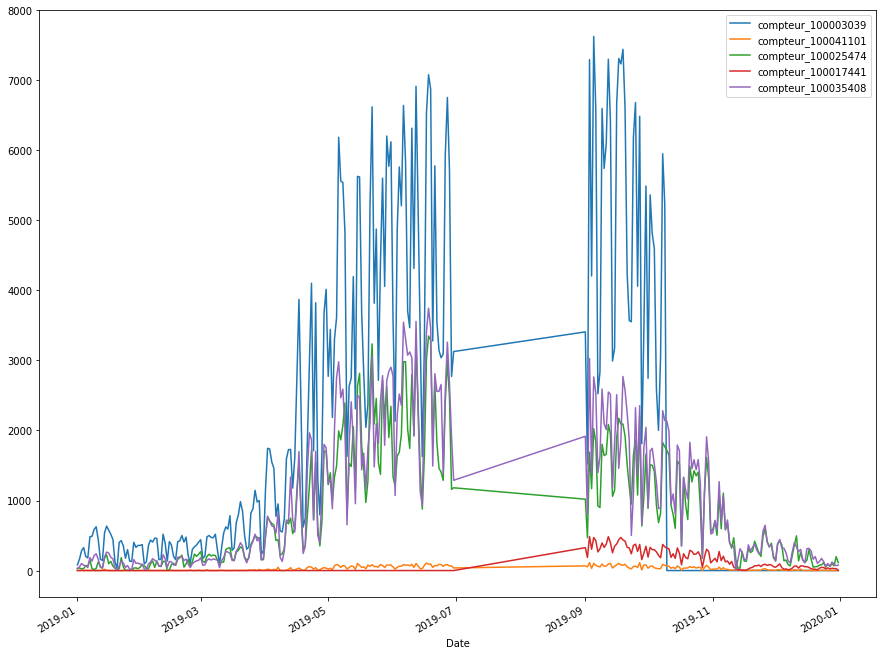

In [6]:
plt.figure(figsize=(15, 12))
df2019[common_markers[0::5]].plot(ax=plt.gca())

It's clear that the data is quite messy - there are missing time spans (blue line around September, green line until April, red line after October). Let's focus on the very cleanest markers for now and we'll come back to modeling the messy data later.

In [7]:
s = (df2019 != 0).sum()
val_counters_2019 = s.index[s >= 300]

s = (df2020 != 0).sum()
val_counters_2020 = s.index[s >= 360]

best_counters = set(val_counters_2020).intersection(val_counters_2019)
best_counters

{'compteur_100003032',
 'compteur_100025474',
 'compteur_100035408',
 'compteur_100053059'}

Only 4 counters! Let's focus on these for now.

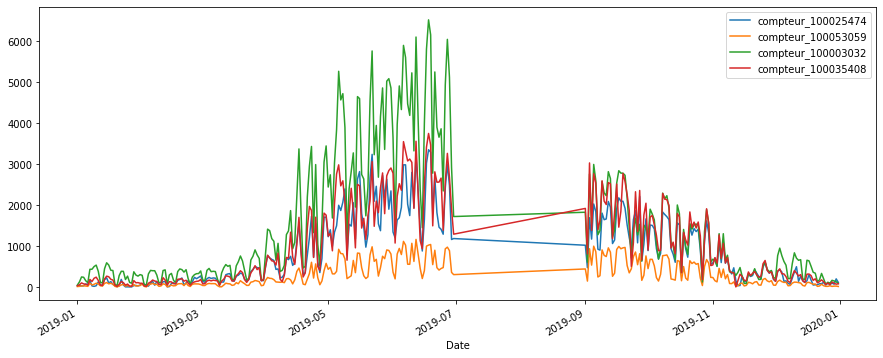

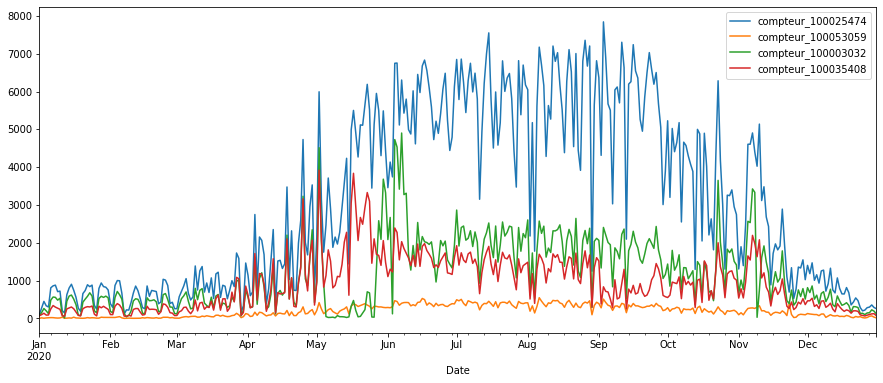

In [8]:
plt.figure(figsize=(15, 6))
df2019[best_counters].plot(ax=plt.gca())
plt.show()
plt.figure(figsize=(15, 6))
df2020[best_counters].plot(ax=plt.gca())
plt.show()

At face value, this shows that some counters have seen 3x increases in uptake (e.g. 100025474), whereas others have had radical decreases in traffic (e.g. 100003032). However, we also see large transients in the data that suggest data quality problems, hence some of these changes are probably artifactual. For instance, because of the installation of security corridors, some of the counters have been moved. It is very difficult to tease apart changes in absolute traffic due to the pandemic compared to changes in absolute traffic due to moving the counters. 

# Changes in daily patterns of use

Let's instead focus on relative changes; these changes are less likely to be affected by calibration issues such as sensor location. Let's measure the week vs. weekend effect. The idea here is that even if a counter is moved by a few meters, leading to changes in absolute numbers recorded, the ratio of the number of trips taken during the week to during the weekend should be about the same - unless there's a radical, sudden change in behaviour. Squinting a bit at the curves, we can already see a pretty big decrease in day-of-week effect, and we expect this to be the case because of work-from-home policies.

In [9]:
we2019 = np.log10(df2019[df2019.index.dayofweek < 5].resample('1W').mean()) - np.log10(df2019[df2019.index.dayofweek >= 5].resample('1W').mean())
we2019[we2019 == np.inf] = np.nan
we2019[we2019 == -np.inf] = np.nan
we2020 = np.log10(df2020[df2020.index.dayofweek < 5].resample('1W').mean()) - np.log10(df2020[df2020.index.dayofweek >= 5].resample('1W').mean())
we2020[we2020 == np.inf] = np.nan
we2020[we2020 == -np.inf] = np.nan

Text(0, 0.5, 'Relative traffic during the week(log10)')

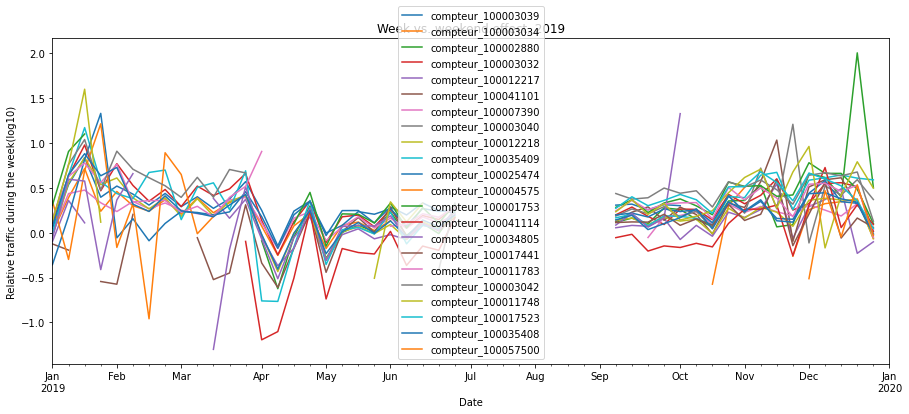

In [10]:
plt.figure(figsize=(15, 6))
we2019[common_markers].plot(ax=plt.gca())
plt.title('Week vs. weekend effect, 2019')
plt.ylabel('Relative traffic during the week(log10)')

In a normal year, week traffic is highest relative to weekend travel during the winter. We see sudden radical shifts around April and May, probably because of very high traffic during nice weather.

Text(0, 0.5, 'Relative traffic during the week(log10)')

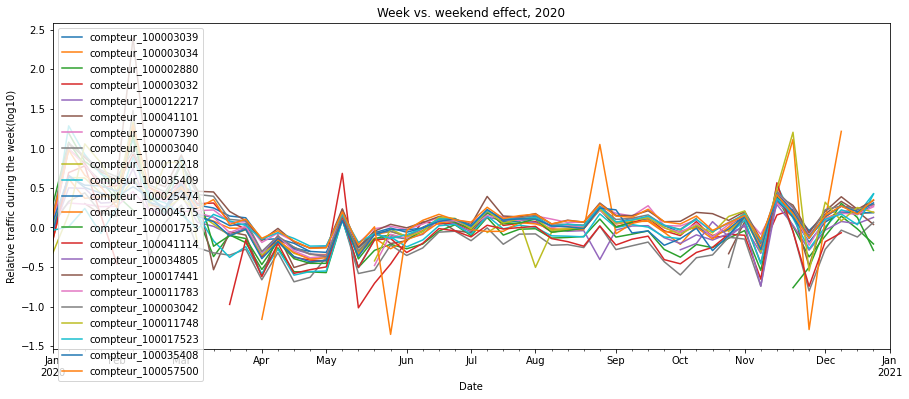

In [11]:
plt.figure(figsize=(15, 6))
we2020[common_markers].plot(ax=plt.gca())
plt.title('Week vs. weekend effect, 2020')
plt.ylabel('Relative traffic during the week(log10)')

In 2020, we see radical shifts in traffic pattern. Week effects go from .3 in the summer to close to 0. Let's measure this difference.

Text(0.5, 1.0, 'Difference in week vs. weekend effect, 2020 - 2019')

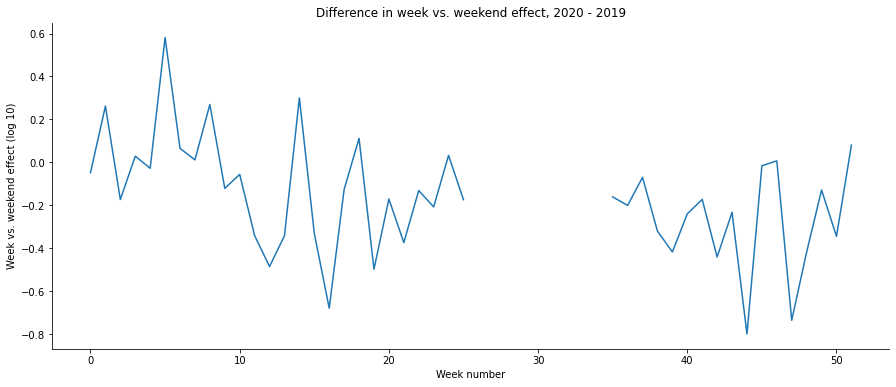

In [12]:
import seaborn as sns

plt.figure(figsize=(15, 6))
df_ = we2019[common_markers]
df_.replace
a = (we2020[common_markers].mean(axis=1).reset_index()[0] - we2019[common_markers].mean(axis=1).reset_index()[0])#.plot(ax=plt.gca())
plt.plot(a)
plt.xlabel('Week number')
plt.ylabel('Week vs. weekend effect (log 10)')
sns.despine()
plt.title('Difference in week vs. weekend effect, 2020 - 2019')

We see that the relative effect hovers around -.3 - meaning that the week vs. weekend effect has been approximately *halved* following the pandemic, reflecting a shift in work commute patterns. 

# Changes in patterns of sensitivity to weather

Can we confirm these patterns of shift from work-heavy bike rides to leisurely bike rides? We expect that leisure trips are more affected by weather than work commutes. Therefore, since the balance of trips has shifted towards leisure, we expect that the weather has had *more* of an effect on trips taken in 2020 than in a normal year. Let's find out. I downloaded climate data from the McTavish reservoir from https://climatedata.ca/download/#station-download to verify this is the case.

In [13]:
common_markers

['compteur_100003039',
 'compteur_100003034',
 'compteur_100002880',
 'compteur_100003032',
 'compteur_100012217',
 'compteur_100041101',
 'compteur_100007390',
 'compteur_100003040',
 'compteur_100012218',
 'compteur_100035409',
 'compteur_100025474',
 'compteur_100004575',
 'compteur_100001753',
 'compteur_100041114',
 'compteur_100034805',
 'compteur_100017441',
 'compteur_100011783',
 'compteur_100003042',
 'compteur_100011748',
 'compteur_100017523',
 'compteur_100035408',
 'compteur_100057500']

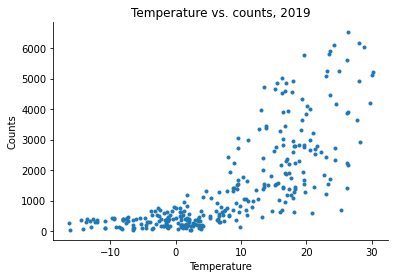

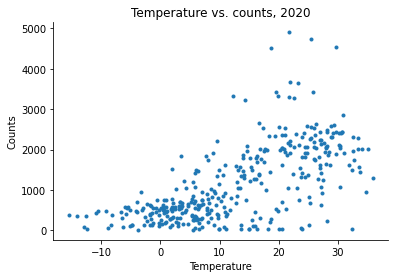

In [14]:
df_weather = pd.read_csv('climate-daily.csv')
df_weather = df_weather.set_index(pd.to_datetime(df_weather.LOCAL_DATE))
#df_weather.MEAN_TEMPERATURE
#df_weather.TOTAL_PRECIPITATION
#df2019
#df_weather.columns
df2019_w = pd.merge(df2019[common_markers], df_weather, left_index=True, right_index=True)
plt.plot(df2019_w.MAX_TEMPERATURE, df2019_w.compteur_100003032, '.')
sns.despine()
plt.xlabel('Temperature')
plt.ylabel('Counts')
plt.title('Temperature vs. counts, 2019')
plt.show()

df2020_w = pd.merge(df2020[common_markers], df_weather, left_index=True, right_index=True)
plt.plot(df2020_w.MAX_TEMPERATURE, df2020_w.compteur_100003032, '.')
sns.despine()
plt.xlabel('Temperature')
plt.ylabel('Counts')
plt.title('Temperature vs. counts, 2020')
plt.show()

As we suspected, temperature affects ridership dramatically.

It's not so clear, however, from this raw data that temperature effects have changed through time, because there are many confounders, in particular precipitation as well as week vs. weekend effects. To verify this, let's use a generative model - a generalized additive model (GAM). We'll assume that in each year, the data is well explained by a nonlinear temperature effect, a day-of-week effect, a nonlinear precipitation effect, and a station identity effect - and that all of these effects are multiplicative. That's easy to do with an exponential inverse link, which transforms additive effects into multiplicative effects. In other words:

$$y \sim \text{Poisson}(\exp(s(T) + s(\text{precipitation}) + I(\text{dow}) + I(\text{station})))$$

Here $s$ corresponds to a spline. Let's use PyGAM to fit this model.

In [15]:
from pygam import PoissonGAM, s, f, l

melted2019 = df2019_w.reset_index().filter(regex='TOTAL_PRECIPITATION|MAX_TEMPERATURE|index|compteur_*', axis=1).melt(['index', 'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION'])
melted2019['dow'] = melted2019['index'].map(lambda x: x.dayofweek)
melted2019['month'] = melted2019['index'].map(lambda x: x.month)

# Drop zeros from counts, and focus on March to November period.
data2019 = melted2019[melted2019.variable.str.startswith('compteur') & 
           (melted2019.value != 0) &  
           (melted2019.month >= 3) &
           (melted2019.month < 12)]

data2019 = data2019.dropna()

# PyGAM wants floats for factors, so transform identifiers to floats
data2019['station_id'] = data2019.variable.str[9:].astype(np.float)

y = data2019.value.values
X = data2019[['MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'dow', 'station_id']].values

# For whatever reason, pygam gives strange estimates with a factor with non-consecutive values
pack_station_id = {x: i for i, x in enumerate(np.unique(X[:, -1]))}
X[:, -1] = [pack_station_id[x] for x in X[:, -1]]

# Do a grid search to find optimal smoothing parameters.
gam = PoissonGAM(s(0) + s(1) + f(2) + f(3), fit_intercept=False)
gam.fit(X, y)

PoissonGAM(callbacks=[Deviance(), Diffs()], fit_intercept=False, 
   max_iter=100, terms=s(0) + s(1) + f(2) + f(3), tol=0.0001, 
   verbose=False)

In [16]:
gam.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     60.8428
Link Function:                          LogLink Log Likelihood:                               -383050.0897
Number of Samples:                         3318 AIC:                                           766221.8651
                                                AICc:                                           766224.253
                                                UBRE:                                              224.791
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.841
Feature Function                  Lam

<ipython-input-16-dec6a6acdaaa>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


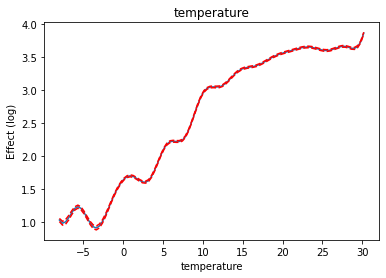

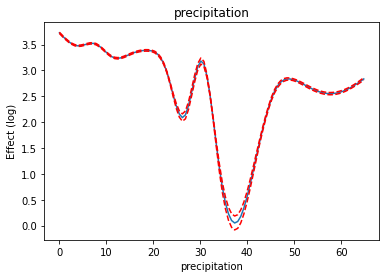

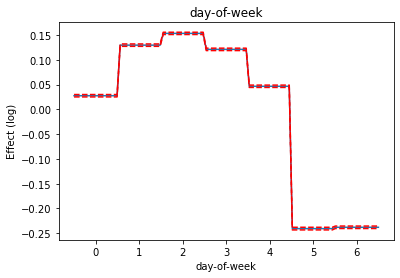

In [18]:
labels = ['temperature', 'precipitation', 'day-of-week']

for i, term in enumerate(gam.terms[:3]):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    XX[:, 3] = X[0, 3]
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    if i == 0:
        tfun = gam.predict(XX)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(labels[i])
    plt.xlabel(labels[i])
    plt.ylabel('Effect (log)')
    plt.show()

We note an almost linear effect of temperature (on the log scale), strong effects of precipitation, as well as a day-of-week effect with higher numbers during the week. Let's repeat this for 2020.

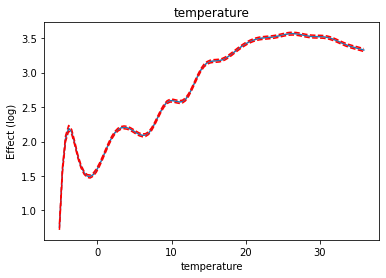

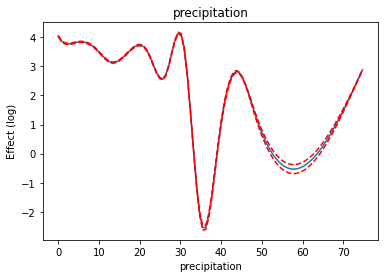

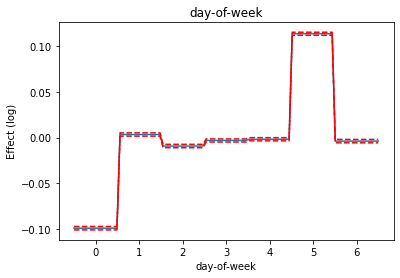

In [20]:
melted2020 = df2020_w.reset_index().filter(regex='TOTAL_PRECIPITATION|MAX_TEMPERATURE|index|compteur_*', axis=1).melt(['index', 'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION'])
melted2020['dow'] = melted2020['index'].map(lambda x: x.dayofweek)
melted2020['month'] = melted2020['index'].map(lambda x: x.month)

# Drop zeros from counts, and focus on March to November period.
data2020 = melted2020[melted2020.variable.str.startswith('compteur') & 
           (melted2020.value != 0) &  
           (melted2020.month >= 3) &
           (melted2020.month < 12)]

data2020 = data2020.dropna()

# PyGAM wants floats for factors, so transform identifiers to floats
data2020['station_id'] = data2020.variable.str[9:].astype(np.float)

y = data2020.value.values
X = data2020[['MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'dow', 'station_id']].values

# For whatever reason, pygam gives strange estimates with a factor with non-consecutive values
pack_station_id = {x: i for i, x in enumerate(np.unique(X[:, -1]))}
X[:, -1] = [pack_station_id[x] for x in X[:, -1]]

# Do a grid search to find optimal smoothing parameters.
gam = PoissonGAM(s(0) + s(1) + f(2) + f(3), fit_intercept=False)
gam.fit(X, y)

labels = ['temperature', 'precipitation', 'day-of-week']

for i, term in enumerate(gam.terms[:3]):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    XX[:, 3] = X[0, 3]
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    if i == 0:
        tfun = gam.predict(XX)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(labels[i])
    plt.xlabel(labels[i])
    plt.ylabel('Effect (log)')
    plt.show()

Wow! We see a complete reversal of the day-of-week effect in 2020, with weekends (days 5-6) showing higher numbers. Perhaps surprisingly, however, the effect of temperature does not appear to be much changed. Let's examine this a little closer - let's concentrate on cases with temperature in the middle ranges - 5 to 25 degrees - where the effect is broadly linear in log space, and let's binarize precipitation at 5 mm.

In [21]:
results = []
for d in [data2019, data2020]:
    d = d.query('MAX_TEMPERATURE >= 5 and MAX_TEMPERATURE <= 25 and station_id != 100057500')
    d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)

    y = d.value.values
    X = d[['MAX_TEMPERATURE', 'has_precipitation', 'dow', 'station_id']].values
    
    # For whatever reason, pygam gives strange estimates with a factor with non-consecutive values
    pack_station_id = {x: i for i, x in enumerate(np.unique(X[:, -1]))}
    X[:, -1] = [pack_station_id[x] for x in X[:, -1]]

    # Do a grid search to find optimal smoothing parameters.
    gam = PoissonGAM(l(0) + l(1) + f(2) + f(3), fit_intercept=False)
    gam.fit(X, y)
    results.append(gam.coef_)
    
    
weather_effect = (results[1] - results[0])[0] / results[1][0]
precipitation_effect = (results[1] - results[0])[1] / results[1][1]

# Calculate day of week effect.
weights = np.array([.2, .2, .2, .2, .2, -.5, -.5])

dow_effect = np.exp(-(results[1][2:9] @ weights - results[0][2:9] @ weights)) - 1

print(f'Temperature effect: {weather_effect:.3f}')
print(f'Precipitation effect: {precipitation_effect:.3f}')
print(f'DOW effect: {dow_effect:.3f}')
dow_effect

Temperature effect: 0.072
Precipitation effect: 0.168
DOW effect: 0.638


<ipython-input-21-a174ba2e2058>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-21-a174ba2e2058>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)


0.6375664030015216

We see that the change in the day of week effect is indeed large - a relative boost of +63% in weekend numbers relative to weekdays. The precipitation effect is smaller - the relative decrease during days with rain (>5mm) is greater by 16% - while the weather effect is smaller still - the temperature to ridership slope is 10% steeper. Are these effects statistically significant? The main epistemic uncertainty is with respect to the counters - we could have placed the counters elsewhere and obtained different results - and we're interested in how these results would generalize if we had counters on every bike path in the city. Thus, let's bootstrap, with the bootstrapping unit being counters.

In [22]:
from tqdm import tqdm

def reweight(X, y, w):
    # Duplicate each row of y and X w times.
    idx = [[i] * w_ for i, w_ in enumerate(w)]
    idx = np.concatenate(idx).astype(np.int)
    
    return X[idx, :], y[idx]


def bootfun():
    units = np.unique(data2019.query("station_id != 100057500").station_id)
    
    # Use the Poisson boostrap to give each unit a weight.
    # https://www.unofficialgoogledatascience.com/2015/08/an-introduction-to-poisson-bootstrap26.html
    ns = {u: x for u, x in zip(units, np.random.poisson(1, len(units)))}
    
    results = []
    for d in [data2019, data2020]:
        d = d.query('MAX_TEMPERATURE >= 5 and MAX_TEMPERATURE <= 25 and station_id != 100057500')
        d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
        d['weight'] = d.station_id.map(lambda x: ns[x])
        y = d.value.values
        X = d[['MAX_TEMPERATURE', 'has_precipitation', 'dow', 'station_id']].values
        
        # For whatever reason, pygam gives strange estimates with a factor with non-consecutive values
        pack_station_id = {x: i for i, x in enumerate(np.unique(X[:, -1]))}
        X[:, -1] = [pack_station_id[x] for x in X[:, -1]]
        
        w = d.weight.values
        #w = np.ones(w.shape).astype(np.int)
        
        X, y = reweight(X, y, w)

        # Do a grid search to find optimal smoothing parameters.
        gam = PoissonGAM(l(0) + l(1) + f(2) + f(3), fit_intercept=False)
        gam.fit(X, y)
        results.append(gam.coef_)


    weather_effect = (results[1] - results[0])[0] / results[1][0]
    precipitation_effect = (results[1] - results[0])[1] / results[1][1]

    # Calculate day of week effect.
    weights = np.array([.2, .2, .2, .2, .2, -.5, -.5])

    dow_effect = np.exp(-(results[1][2:9] @ weights - results[0][2:9] @ weights)) - 1
    return np.array([weather_effect, precipitation_effect, dow_effect])

measures = []
for i in range(100):
    measures.append(bootfun())
    
measures = np.array(measures)

print([np.mean(measures, axis=0) - 1.96 * np.std(measures, axis=0), [np.mean(measures, axis=0) + 1.96 * np.std(measures, axis=0)]])
print(np.mean(measures, axis=0))

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

[array([-0.02760081,  0.10046998,  0.37036489]), [array([0.18304513, 0.23748639, 0.89662229])]]
[0.07772216 0.16897819 0.63349359]


<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['has_precipitation'] = 1*(d.TOTAL_PRECIPITATION > 5)
<ipython-input-22-a2159733b629>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['weight'] = d.station_id.map(lambda x: ns[x])
<ipython-input-22-a2159733b629>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [23]:
m = [np.mean(measures, axis=0),
           np.mean(measures, axis=0) - 1.96 * np.std(measures, axis=0),
           np.mean(measures, axis=0) + 1.96 * np.std(measures, axis=0)]

labels = ['Temperature', 'Precipitation', 'Day-of-week']
for i, label in enumerate(labels):
    print(f"{labels[i]}: {m[0][i]:.3f} [{m[1][i]:.3f}, {m[2][i]:.3f}]")

Temperature: 0.078 [-0.028, 0.183]
Precipitation: 0.169 [0.100, 0.237]
Day-of-week: 0.633 [0.370, 0.897]


We can see that the day-of-week and precipitation effects are highly statistically significant, but the temperature effect is not - the confidence interval contains zero. 

## Absolute vs. relative effects

So we see that we can confidently measure relative effects, but have yet to confirm absolute effects - can we see absolute effects? We'd expect to see decreases in use of bike paths near downtown, that are used for commuting to work, but potential increases in leisure bike paths. Is this the case?

In [24]:
rel_effect = results[1][9:] - results[0][9:]
imap = {v:k for k, v in pack_station_id.items()}

station_effects = pd.DataFrame([{'rel_effect': x, 'station_id': imap[i]} for i, x in enumerate(rel_effect)])
station_effects = pd.merge(station_effects, markers, left_on = 'station_id', right_on='ID')

In [139]:
from ipywidgets import HTML
from ipyleaflet import Map, Marker
from ipyleaflet import AwesomeIcon, Marker, Map, Choropleth, CircleMarker, Popup

import matplotlib as mpl
import matplotlib.cm as cm

def get_features(df):
    feats = []
    vals = {}
    theta = np.arange(16) / 16 * 2 * np.pi
    r = .002
    
    for i, row in df.iterrows():
        coords = (np.stack([np.cos(theta) * r, np.sin(theta) * r], axis=1) + 
                  np.array([row.Longitude, row.Latitude]))
        
        feats.append({
            "type":"Feature",
            "id":row.ID,
            "properties": {"name": row.Nom},
            "geometry":{
                "type":"Polygon",
                "coordinates": [coords.tolist()]
            }
        })
        vals[row.ID] = row.rel_effect
    return feats, vals

def get_markers(df, m):
    
    vmin, vmax = (-1*abs(df.rel_effect).max(), 1*abs(df.rel_effect).max())
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.seismic

    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    for i, row in df.iterrows():
        col = mpl.colors.rgb2hex(mapper.to_rgba(row.rel_effect))
        marker = CircleMarker(location=(row.Latitude, row.Longitude),
                              fill_color=col,
                              weight=1,
                              fill_opacity=.8,
                              color='#000')
        marker.popup = Popup(location=center, child=HTML(value=f"{row.Nom}: {np.exp(row.rel_effect):.2f}X"))

        m.add_layer(marker)


center = (45.5133787,-73.6)

m = Map(center=center, zoom=12)
get_markers(station_effects, m)
m

Map(center=[45.5133787, -73.6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

There is not much rhyme or reason to the pattern of changes - some counters see large increases, while others which are very close nearby - e.g. on the Plateau - see large decreases. We do see that larger increases in traffic near Parc Lafontaine, Parc Stanley and Parc Mont-Royal - which could be reflections of patterns towards more leisure activities.

Overall, we can see that an approach based on relative changes in time can follow changes in behaviour. During the pandemic, traffic patterns shifted towards leisure, with greater However, absolute metrics can be misleading, as changes in sensor placement and local traffic conditions can change absolute readings in ways that are difficult to tease apart. Increasing sensor density and having audit data to compare automated sensor readings to manual census would improve data quality, and could allow the city to track usage patterns more precisely over time - potentially helping to plan future bike paths. 